# Simulating ancestry with msprime

10.30am

This is the first of two sessions about `msprime`, a backwards-time tree sequence simulator. In this first worksheet, we will learn how to design simulations using customisable models of genomic history. In the next session, we will add mutations to these simulated histories to obtain sequence data.

#### Some relevant papers:
 -  [Efficient coalescent simulation and genealogical analysis for large sample sizes](https://doi.org/10.1371/journal.pcbi.1004842)
 - [Efficient ancestry and mutation simulation with msprime 1.0](https://doi.org/10.1093/genetics/iyab229)
 - [tskit.dev documentation](https://tskit.dev/)
 
Simulations are important in population genetics for many reasons:

**Exploration:**
Simulations allow us to explore the influence of various historical scenarios on observed patterns of genetic variation and inheritance.

**Benchmarking and evaluating methodologies:**
To assess the accuracy of inferential methods, we need test datasets for which the true values of important parameters are known.

**Model training:**
Some methods for ancestry inference are trained on simulated data (eg. Approximate Bayesian Computation).
This is especially important in studies of complex demographies, where there are many potential parameters and models, making it impractical to specify likelihood functions.

### A brief history of msprime

The first release of `msprime` was an emulation of the popular `ms` coalescent simulator with added support for tree sequences.
However, it has since become an expansive and flexible backwards-in-time simulator for various different models of genetic ancestry and mutation, and even for simplified models of selection.

#### Forwards and backwards simulation

The main characteristic of `msprime` is that is simulates *tree sequences* in *backwards-time*.

<img src="pics/msprime-1.png" width="200" height="200">
<img src="pics/msprime-2.png" width="200" height="200">
<img src="pics/msprime-3.png" width="200" height="200">
<img src="pics/msprime-4.png" width="200" height="200">
<img src="pics/msprime-5.png" width="200" height="200">

The alternative is to use a *forwards-time* simulator like `SLiM`:

<img src="pics/slim-1.png" width="200" height="200">
<img src="pics/slim-2.png" width="200" height="200">
<img src="pics/slim-3.png" width="200" height="200">
<img src="pics/slim-4.png" width="200" height="200">
<img src="pics/slim-5.png" width="200" height="200">
<img src="pics/slim-6.png" width="200" height="200">
<img src="pics/slim-7.png" width="200" height="200">
<img src="pics/slim-8.png" width="200" height="200">
<img src="pics/slim-9.png" width="200" height="200">
<img src="pics/slim-10.png" width="200" height="200">

In general, forwards-time simulation with `SLiM` is *detailed* and *more realistic*,
while backwards-time simulation with `msprime` is *fast* and *efficient*.
`msprime` is designed for *neutral* simulations, while `SLiM` is better suited to complex simulations, including those involving selection.

However, `pyslim` allows you to combine these via a process called 'recapitation'.
See (link) if this is of interest.

<img src="pics/recapitation-1.png" width="400" height="400">
<img src="pics/recapitation-2.png" width="400" height="400">

In [1]:
import msprime
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG

### Basic syntax

(10.40am)

To simulate a tree sequence in `msprime`, we use the `sim_ancestry()` method:

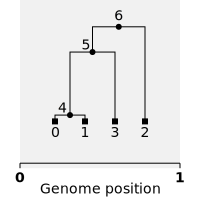

In [2]:
ts = msprime.sim_ancestry(samples=2, random_seed=1)
SVG(ts.draw_svg())

In [3]:
ts

## Specifying contig information
Although we have specified 2 samples, our tree sequence contains 4 sample nodes.
This is because the `samples` argument specifies the number of *individuals* in the sample,
and by default, `sim_ancestry()` assumes diploid organisms.
To change this, use the `ploidy` argument:

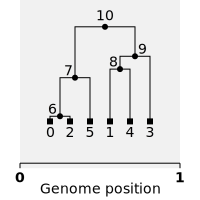

In [4]:
ts = msprime.sim_ancestry(samples=2, random_seed=1, ploidy=3)
SVG(ts.draw_svg())

It's easiest to start thinking about genome lengths in units of nucleotides. By default, we are simulating a sequence length that spans just one of these units.
We can specify a larger region using the `sequence_length` argument:

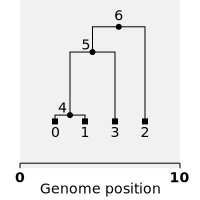

In [5]:
ts = msprime.sim_ancestry(samples=2, random_seed=1, sequence_length=10)
SVG(ts.draw_svg())

Also, note that our 'tree sequence' consists of just a single tree. This is because we have not yet specified a `recombination_rate`, and the default is 0. 
This is the probability of a recombination event per genomic unit (base), per generation.

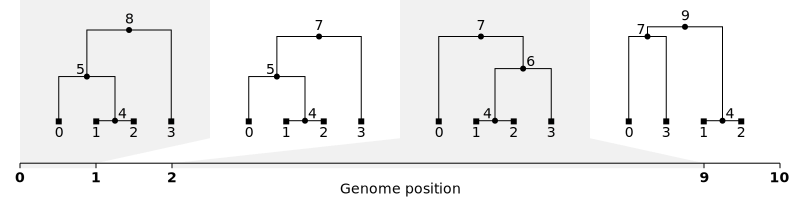

In [6]:
ts = msprime.sim_ancestry(
                samples=2,
                random_seed=82,
                sequence_length=10,
                recombination_rate=0.1)
SVG(ts.draw_svg())

We may also wish to specify recombination rates that vary across the genome. 
We do this by creating a `RateMap` object,
which lists recombination rates between defined positions in the sequence.

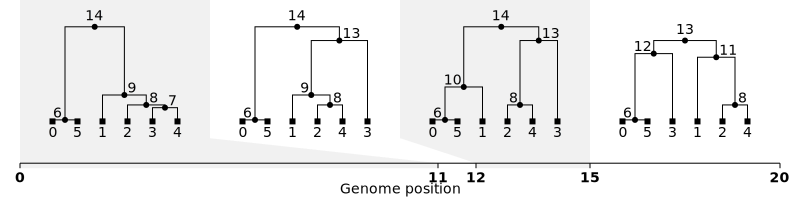

In [7]:
rate_map = msprime.RateMap(position=[0, 10, 20], rate=[0.01, 0.1])
ts = msprime.sim_ancestry(3, recombination_rate=rate_map, random_seed=2)
SVG(ts.draw_svg())

Note that it's also possible to simulate gene conversion in `msprime`.
If this is of interest, have a look at the API documentation for the `gene_conversion_rate` and `gene_conversion_tract_length` arguments,
and [this](https://tskit.dev/msprime/docs/stable/ancestry.html?highlight=gene%20conversion#gene-conversion) short tutorial.


By default, the recombination events will be assigned to integer locations along the sequence. However there may be situations where you want to model the genome using continuous coordinates. In this case, use the `discrete_genome=False` argument:

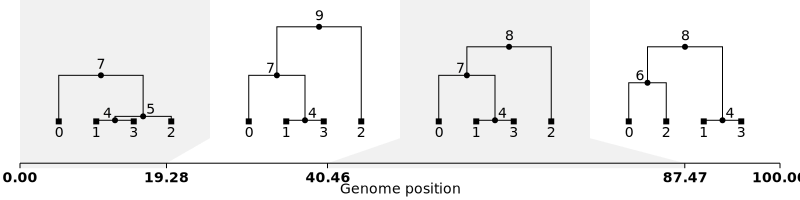

In [8]:
ts = msprime.sim_ancestry(
    samples=2, random_seed=28, sequence_length=100,
    recombination_rate=0.01, discrete_genome=False)
SVG(ts.draw_svg())

(10.55am)

*Exercise:* Our study organisms have a ploidy of 3 and a chromosome of length 100.
Between the bases at positions 50 and 60, there is a recombination 'hotspot' with a higher recombination rate of 0.1.
Modify the following code to simulate chromosomes for 2 such organisms.

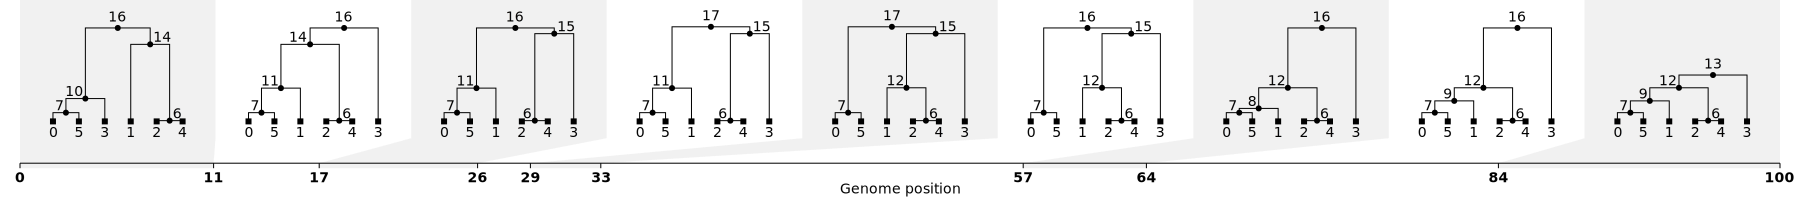

In [9]:
rate_map = msprime.RateMap(position=[0, 100], rate=[0.01])
ts = msprime.sim_ancestry(samples=3,
                          recombination_rate=rate_map,
                          random_seed=193)
SVG(ts.draw_svg())

## Demographic history

(11am)

So far, we have been simulating samples from a single population of a constant size, which isn’t particularly exciting! One of the strengths of msprime is that it can be used to specify quite complicated models of demography and population history with a simple Python API.

### Population size

So far, we've assumed our samples and all their ancestors belong to a single population with $2N_e=1$, which scales the simulation to use classical coalescent time units of $\frac{1}{2N_e}$. (Note that `msprime` scales this for different ploidies, also).

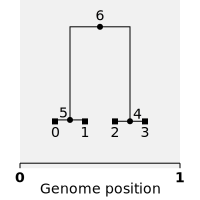

In [10]:
ts = msprime.sim_ancestry(samples=2, random_seed=234)
SVG(ts.draw_svg())

In [11]:
tree = ts.first()
print("Total branch length:", tree.total_branch_length)
print("Time at root:", ts.tables.nodes.time[tree.root])

Total branch length: 14.394580159518803
Time at root: 7.136285694725596


By specifying a specific population size using the `population_size` argument, all times and branch lengths will be rescaled into units of generations.

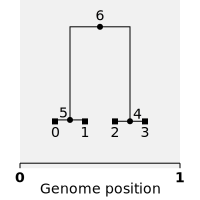

In [12]:
ts = msprime.sim_ancestry(
    samples=2,
    random_seed=234,
    population_size=2)
SVG(ts.draw_svg())

In [13]:
tree = ts.first()
print("Total branch length:", tree.total_branch_length)
print("Time at root:", ts.tables.nodes.time[tree.root])

Total branch length: 28.789160319037606
Time at root: 14.272571389451192


Note that this population size should be the number of *individuals*, not the number of genomes. `msprime` uses the supplied `ploidy` to do all the other necessary adjustments under-the-hood.

In [14]:
ts = msprime.sim_ancestry(
    samples=1,
    ploidy=4,
    random_seed=234,
    population_size=2)

tree = ts.first()
print("Total branch length:", tree.total_branch_length)
print("Time at root:", ts.tables.nodes.time[tree.root])

Total branch length: 57.57832063807521
Time at root: 28.545142778902385


### Population structure

(11.05am)

To simulate under more complicated models of demographic history, we will need to create a `msprime.Demography` object.
`msprime` supports simulation from multiple discrete populations, each of which is initialized via the `add_population()` method.
For each population, you can specify a sample size, an effective population size, an exponential growth rate and a name.

We could have specified our previous simulation with the following code:

In [15]:
dem = msprime.Demography()
dem.add_population(
    name="my_pop",
    initial_size=1
)
dem

id,name,description,initial_size,growth_rate,default_sampling_time,extra_metadata
0,my_pop,,1.0,0,0,{}


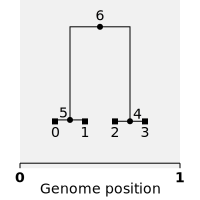

In [16]:
ts = msprime.sim_ancestry(
    samples=2,
    random_seed=234,
    demography=dem
)
SVG(ts.draw_svg())

We can also use `Population` objects to specify an exponential growth rate of the population per generation (i.e. forwards in time)

<img src="pics/worksheet2-dem1.png" width="400" height="400">

In [17]:
dem = msprime.Demography()
dem.add_population(
    name="my_pop",
    initial_size=1e5,
    growth_rate=0.1
)
dem

id,name,description,initial_size,growth_rate,default_sampling_time,extra_metadata
0,my_pop,,100000.0,0.1,0,{}


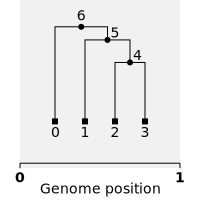

In [18]:
ts = msprime.sim_ancestry(
    samples=2,
    random_seed=11,
    demography=dem
)
SVG(ts.draw_svg())

Note that the recent branches are much longer than the older ones.
This is what we expect to see in a growing population.

We can add any number of populations into our `Demography` objects.

In [19]:
dem = msprime.Demography()
dem.add_population(
    name="R",
    description="Red population",
    initial_size=500
)
dem.add_population(
    name="B",
    description="Blue population",
    initial_size=500,
    growth_rate=0.0001
)
dem

id,name,description,initial_size,growth_rate,default_sampling_time,extra_metadata
0,R,Red population,500.0,0,0,{}
1,B,Blue population,500.0,0.0001,0,{}


<img src="pics/worksheet2-dem2.png" width="400" height="400">

However, this simulation will run forever unless we also specify some migration between the groups!

In [20]:
# # without an end_time, THIS WILL RUN FOREVER!

# ts = msprime.sim_ancestry(
#   samples={"R" : 3, "B" : 3}, 
#   demography=dem,
#   random_seed=12,
#   sequence_length=1000, 
#   )

To understand why, recall that msprime is a backwards-time simulator. The simulation will run beginning from the present day working further back in time, simulating until all samples have coalesced to a single common ancestor at each genomic location. However, with no migration between our two populations, samples in one population will never coalesce with samples in another population. To fix this, let’s add some migration events.

### Migration

With msprime, you can specify continual rates of migrations between populations, as well as admixture events, divergences and one-off mass migrations.


**Migration rates** are passed to our `msprime.Demography` object individually via the `set_migration_rate()` method.
This allows us to specify the expected number of migrants moving from population `dest` to population `source` per generation, divided by the size of population `source`. When this rate is small (close to 0), it is approximately equal to the fraction of population `source` that consists of new migrants from population `dest` in each generation. 

If both of your populations are exchanging migrants at the same rate, you can save yourself some typing by specifying them with a single `set_symmetric_migration_rate()` call.
See the documentation [here](https://tskit.dev/msprime/docs/stable/api.html#msprime.Demography.add_symmetric_migration_rate_change).

In [21]:
dem = msprime.Demography()
dem.add_population(
    name="R",
    description="Red population",
    initial_size=500
)
dem.add_population(
    name="B",
    description="Blue population",
    initial_size=500,
    growth_rate=0.0001
)
dem

# Set migration rates.
dem.set_migration_rate(source=0, dest=1, rate=0.05)
dem.set_migration_rate(source=1, dest=0, rate=0.02)

For instance, the `Demography` object above specifies that in each generation, approximately 5% of the red population (0) consists of migrants from the blue population (1), and approximately 2% of the blue population consists of migrants from the red population.

In [22]:
# Simulate.
ts = msprime.sim_ancestry(
  samples={"R" : 5, "B" : 5},
  demography=dem,
  sequence_length=1e7,
  random_seed=145)
ts

One consequence of explicitly specifying `Population` objects is that each of the simulated nodes will now belong to one of our specified populations:

In [23]:
ts.tables.nodes

id,flags,population,individual,time,metadata
0,1,0,0,0.00000000,b''
1,1,0,0,0.00000000,b''
2,1,0,1,0.00000000,b''
3,1,0,1,0.00000000,b''
4,1,0,2,0.00000000,b''
5,1,0,2,0.00000000,b''
6,1,0,3,0.00000000,b''
7,1,0,3,0.00000000,b''
8,1,0,4,0.00000000,b''
9,1,0,4,0.00000000,b''


In [24]:
ts.tables.populations

id,metadata
0,"{'description': 'Red population', 'name': 'R'}"
1,"{'description': 'Blue population', 'name': 'B'}"


We'll use this information to draw the tree sequence with nodes coloured by population label using SVG:

Tree on interval: Interval(left=0.0, right=10000000.0)


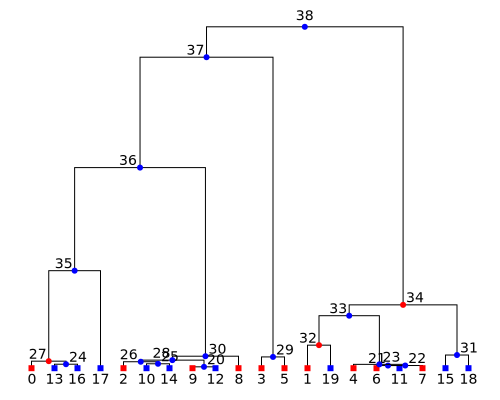

In [25]:
colour_map = {0:"red", 1:"blue"}
node_colours = {u.id: colour_map[u.population] for u in ts.nodes()}
for tree in ts.trees():
    print("Tree on interval:", tree.interval)
    # The code below will only work in a Jupyter notebook with SVG output enabled.
    display(SVG(tree.draw(node_colours=node_colours, width=500, height=400)))

More coalescences are happening in the blue population (1) than the red population (0). This makes sense given that population 1 is specifying more migrants to population 0 than vice versa.

### Changing migration rates

(11.15am)

We can change any of the migration rates at any time in the simulation. To do this, we'll use the `add_migration_rate_change()` method on our demography object.
This will specify the populations whose migration rates are to be changed, the time of the change and the new migration rate.

For instance, say we wanted to specify that in each generation prior to `time=100`, 1% of the red population (0) consisted of migrants from the blue population (1).

In [26]:
dem.add_migration_rate_change(time=100, rate=0.01, source=0, dest=1)
dem

Demography(populations=[Population(initial_size=500, growth_rate=0, name='R', description='Red population', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=500, growth_rate=0.0001, name='B', description='Blue population', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1)], events=[MigrationRateChange(time=100, rate=0.01, source=0, dest=1)], migration_matrix=array([[0.  , 0.05],
       [0.02, 0.  ]]))

The output above shows that we have successfully added our first demographic event to our `Demography` object, a migration rate change. We are now ready to simulate:

In [27]:
ts = msprime.sim_ancestry(
  samples={"R" : 4, "B" : 4},
  demography=dem,
  sequence_length=1000,
  random_seed=63461)
ts

Tree on interval: Interval(left=0.0, right=1000.0)


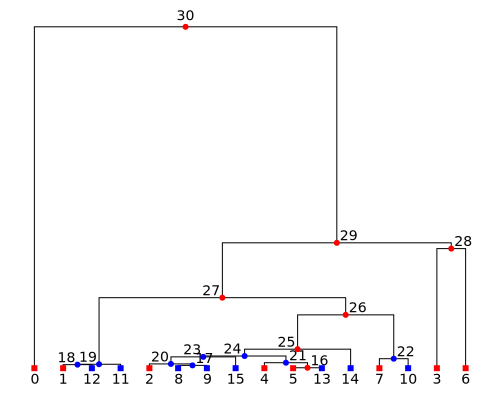

In [28]:
colour_map = {0:"red", 1:"blue"}
node_colours = {u.id: colour_map[u.population] for u in ts.nodes()}
for tree in ts.trees():
    print("Tree on interval:", tree.interval)
    # The code below will only work in a Jupyter notebook with SVG output enabled.
    display(SVG(tree.draw(node_colours=node_colours, width=500, height=400)))

### Admixture

(11.25am)

It is also easy to specify admixture and divergence events with `msprime`. Suppose we wanted to specify our demography so that our admixed population arose 200 generations ago, with 70% of the new population being migrants from the red ancestral population, and 30% being migrants from the blue ancestral population.

<img src="pics/worksheet2-dem3.png" width="400" height="400">

We can do this by using the `add_admixture()` method on our demography object. We must supply a list of ancestral populations participating in the admixture, and a list of the same size specifying the proportions of migrants from each of these populations.

In [29]:
dem = msprime.Demography()
dem.add_population(
    name="AncestralPop0", description="Plotted in red.", initial_size=1000, growth_rate=0)
dem.add_population(
    name="AncestralPop1", description="Plotted in blue.", initial_size=1000, growth_rate=0)
dem.add_population(
    name="AdmixedPop", description="Plotted in purple.", initial_size=700)
dem.set_migration_rate(
    source=0, dest=1, rate=0.001)
dem.set_migration_rate(
    source=1, dest=0, rate=0.001)

# Specify admixture event.
dem.add_admixture(time=200, derived="AdmixedPop", ancestral=["AncestralPop0", "AncestralPop1"], proportions=[0.6, 0.4])
dem

Demography(populations=[Population(initial_size=1000, growth_rate=0, name='AncestralPop0', description='Plotted in red.', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=1000, growth_rate=0, name='AncestralPop1', description='Plotted in blue.', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=700, growth_rate=0, name='AdmixedPop', description='Plotted in purple.', extra_metadata={}, default_sampling_time=None, initially_active=None, id=2)], events=[Admixture(time=200, derived='AdmixedPop', ancestral=['AncestralPop0', 'AncestralPop1'], proportions=[0.6, 0.4])], migration_matrix=array([[0.   , 0.001, 0.   ],
       [0.001, 0.   , 0.   ],
       [0.   , 0.   , 0.   ]]))

In this simulated sample, all of the recent ancestral haplotypes belong to the admixed population, and all of those prior to the admixture event belong to one of the ancestral populations.

In [30]:
ts = msprime.sim_ancestry(
  samples={"AncestralPop0" : 0, "AncestralPop1" : 0, "AdmixedPop" : 6},
  demography=dem,
  sequence_length=1000,
  random_seed=63
)

print("Populations of nodes from time < 500:")
print([u.population for u in ts.nodes() if u.time < 500])
print("Populations of nodes from time >= 500:")
print([u.population for u in ts.nodes() if u.time >= 500])

Populations of nodes from time < 500:
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Populations of nodes from time >= 500:
[0, 1, 1, 0, 0]


Tree on interval: Interval(left=0.0, right=1000.0)


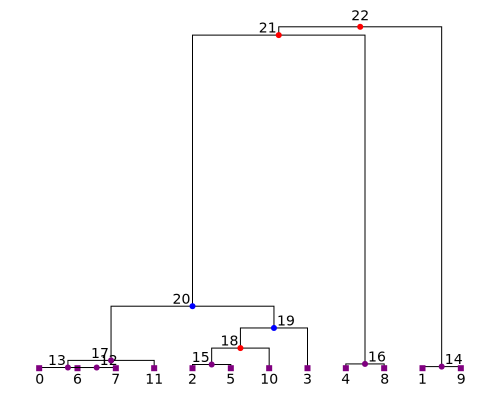

In [31]:
colour_map = {0:"red", 1:"blue", 2:"purple"}
node_colours = {u.id: colour_map[u.population] for u in ts.nodes()}
for tree in ts.trees():
    print("Tree on interval:", tree.interval)
    # The code below will only work in a Jupyter notebook with SVG output enabled.
    display(SVG(tree.draw(node_colours=node_colours, width=500, height=400)))

Admixtures and population splits are special types of demographic events that affect the state of some of the defined populations, in addition to moving lineages between populations. The output below shows that by adding the admixture event, we are triggering a change in the state of `AdmixedPop` at `time = 50`; the population is active at the start of the simulation, but becomes inactive for all steps of the simulation beyond time 50.

In [32]:
dem

Demography(populations=[Population(initial_size=1000, growth_rate=0, name='AncestralPop0', description='Plotted in red.', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=1000, growth_rate=0, name='AncestralPop1', description='Plotted in blue.', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=700, growth_rate=0, name='AdmixedPop', description='Plotted in purple.', extra_metadata={}, default_sampling_time=None, initially_active=None, id=2)], events=[Admixture(time=200, derived='AdmixedPop', ancestral=['AncestralPop0', 'AncestralPop1'], proportions=[0.6, 0.4])], migration_matrix=array([[0.   , 0.001, 0.   ],
       [0.001, 0.   , 0.   ],
       [0.   , 0.   , 0.   ]]))

This means that, for example, adding any demographic events that affect the AdmixedPop before this time will produce an error:

In [33]:
# # THIS WON'T WORK
# dem.add_migration_rate_change(time=80, rate=0.01, source="AncestralPop0", dest="AdmixedPop");
# ts = msprime.sim_ancestry(
#   samples={"AncestralPop0" : 0, "AncestralPop1" : 0, "AdmixedPop" : 6},
#   demography=dem,
#   sequence_length=1000,
#   random_seed=63,
#   recombination_rate=1e-7)

### Population splits

(11.25am)

We can also simulate population divergences with msprime. Suppose we want to model a situation where all lineages from multiple populations are migrants from a single ancestral population at a single point in time.

<img src="pics/worksheet2-dem4.png" width="400" height="400">

We’ll specify this with the `add_population_split()` method. We need to know the time of the event, and the IDs of the derived and ancestral populations participating in the divergence event.

Notice that in this case, we do not need to provide proportions as we did in the case of admixture. This makes sense when you consider that `msprime` simulates backwards-in-time: all lineages in all of the derived populations originate from the ancestral population in a split event. Any differences in ‘quantities’ of migrants must be modelled by sizes of the derived populations at the time of the split.

In [34]:
dem = msprime.Demography()
dem.add_population(name="R", description="Plotted in red.", initial_size=500)
dem.add_population(name="B", description="Plotted in blue.",initial_size=500)
dem.add_population(name="AncestralPopulation", description="Plotted in green.", initial_size=500)

# Add the population split.
dem.add_population_split(time=100, derived=["R","B"], ancestral="AncestralPopulation")
dem

Demography(populations=[Population(initial_size=500, growth_rate=0, name='R', description='Plotted in red.', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=500, growth_rate=0, name='B', description='Plotted in blue.', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=500, growth_rate=0, name='AncestralPopulation', description='Plotted in green.', extra_metadata={}, default_sampling_time=100, initially_active=False, id=2)], events=[PopulationSplit(time=100, derived=['R', 'B'], ancestral='AncestralPopulation')], migration_matrix=array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]))

Population splits will also modify the state of each of the derived populations, changing them from active to inactive at the time of the split.

In [35]:
ts = msprime.sim_ancestry(
  samples={"R" : 3, "B" : 3, "AncestralPopulation" : 0},
  demography=dem,
  sequence_length=1000,
  random_seed=63
)

print("Populations of nodes from time < 100:")
print([u.population for u in ts.nodes() if u.time < 100])
print("Populations of nodes from time >= 100:")
print([u.population for u in ts.nodes() if u.time >= 100])

Populations of nodes from time < 100:
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0]
Populations of nodes from time >= 100:
[2, 2, 2, 2, 2, 2, 2, 2]


### Changing population sizes or growth rates

(11.35am))

We also may wish to specify changes to rates of population growth, or sudden changes in population size at a particular time. Both of these can be specified by applying the `add_population_parameters_change()` method to our `Demography` object.

<img src="pics/worksheet2-dem5.png" width="400" height="400">

In [38]:
dem = msprime.Demography()
dem.add_population(name="R", description="Plotted in red.", initial_size=500)
dem.add_population(name="B", description="Plotted in blue.",initial_size=500)
dem.set_migration_rate(source=0, dest=1, rate=0.05)
dem.set_migration_rate(source=1, dest=0, rate=0.02)

# Bottleneck in Population 0 between 50 - 150 generations ago.
dem.add_population_parameters_change(time=50, initial_size=250, population=0)
dem.add_population_parameters_change(time=150, initial_size=500, population=0)

# Exponential growth in Population 1 starting 50 generations ago.
dem.add_population_parameters_change(time=100, growth_rate=0.01, population=1)

# Sort events, since we've added some out of time order.
dem.sort_events()

In [39]:
# Simulate.
ts = msprime.sim_ancestry(
    samples={"R" : 3, "B" : 3},
    demography=dem,
    sequence_length=1000,
    random_seed=63461
)

Note that because `msprime` simulates backwards-in-time, parameter changes must be interpreted backwards-in-time as well. For instance, the population growth event in the example above specifies continual growth in the early history of population 1 up until 100 generations in the past.

## Debugging demography

(11.40am)

To help you spot any mistakes in your specified demography, `msprime` provides a debugger that prints out your population history in a more human-readable form. It’s good to get into the habit of running this debugger before running your simulations.

In [40]:
my_history = msprime.DemographyDebugger(demography=dem)
my_history

You can also use the debugger to perform some informative calculations based on the given demography.

/miniconda3/lib/python3.7/site-packages/msprime/demography.py:4321: UserWarning: Doubling the number of steps has resulted in different  predictions, please re-run with smaller step sizes to ensure  numerical accuracy.
  "Doubling the number of steps has resulted in different "


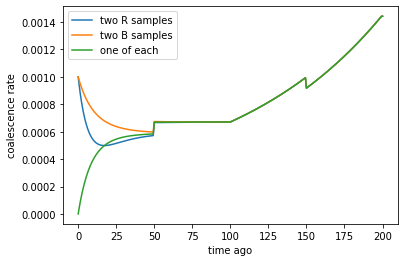

In [41]:
T = np.linspace(0, 200, 301)
RAA, _ = my_history.coalescence_rate_trajectory(T, {"R": 2})
RBB, _ = my_history.coalescence_rate_trajectory(T, {"B": 2})
RAB, _ = my_history.coalescence_rate_trajectory(T, {"R": 1, "B": 1})

plt.plot(T, RAA, label="two R samples")
plt.plot(T, RBB, label="two B samples")
plt.plot(T, RAB, label="one of each")
plt.legend()
plt.xlabel("time ago")
plt.ylabel("coalescence rate");

See [the documentation](https://tskit.dev/msprime/docs/stable/demography.html#sec-demography-numerical) for more examples.

## Other ancestry models

(11.45am)

When might `msprime`'s default (Hudson coalescent) model of genealogy not be ideal for you? Consider the following assumptions it makes:

 - Selective neutrality
 - Random mating and survival outcomes
 - Sample is small relative to population size
 
However, it is possible to simulate from a selection of other models in `msprime` as well! 
The full list is [here](https://tskit.dev/msprime/docs/stable/ancestry.html#sec-ancestry-quickref).

### Discrete-time Wright-Fisher

DTWF simulations are less efficient than coalescent simulations, but should perform better

 - on analyses of very recent history (especially for haplotype-based information like identity-by-descent and local ancestry)
 - on small populations, or when sample size is a large fraction of the population size
 - when modelling very long range correlations across chromosomes is important
 
See [this paper](https://doi.org/10.1371/journal.pgen.1008619) for a more comprehensive comparison between DTWF and coalescent simulations.

Consider the following (coalescent) simulation of two individuals in a population of two.

In [ ]:
ts = msprime.sim_ancestry(
                samples=2,
                population_size=2,
                random_seed=82,
                sequence_length=20,
                recombination_rate=0.3)
SVG(ts.draw_svg())

Notice that we now have over 4 distinct chromosomes within a single generation, and indeed, some of these chromosomes inherit from multiple ancestors within a single generation.

In [ ]:
ts.tables.nodes

This is no longer a problem when we use a discrete-time Wright-Fisher simulation:

In [ ]:
# DTWF sim
ts = msprime.sim_ancestry(
                samples=2,
                population_size=2,
                model=msprime.DiscreteTimeWrightFisher(),
                random_seed=82,
                sequence_length=10,
                recombination_rate=0.2)
SVG(ts.draw_svg())

In [ ]:
ts.tables.nodes

### Simple selective sweeps

We can also run simple simulations of genic selection using a structured coalescent model:

In [ ]:
sweep_model = msprime.SweepGenicSelection(
    position=1,  # start of chrom
    start_frequency=0.2,
    end_frequency=0.8,
    s=0.25,
    dt=1e-5,
)

ts = msprime.sim_ancestry(
    samples=3,
    sequence_length=5e7,
    population_size=100,
    model=sweep_model,
    recombination_rate=1e-8,
    random_seed=123456)
SVG(ts.draw_svg())

We'd recommend using `SLiM` if selection is an important part of your demographic model.

## Mixing different ancestry models

(11.52am)

You can also combine multiple ancestry models inside a single `msprime` simulation. Here's a simple example involving a hybrid DTWF and coalescent simulation:

In [ ]:
models=[msprime.DiscreteTimeWrightFisher(duration=500),
        msprime.StandardCoalescent()]

In [ ]:
ts = msprime.sim_ancestry(
    10,
    population_size=100,
    sequence_length=1e6,
    recombination_rate=1e-8,
    model=models,
    random_seed=6789
)